# Overview of the nmrtools Top-Level API

This notebook gives a tour of the top level classes the nmrtools API provides. These are conveniences that abstract away lower-level API functions. Users wanting more control can consult the full API documentation. 

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry

In [3]:
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

In [4]:
tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

## Definitions

In naming classes, functions, methods etc. certain phrases, taken from NMR nomenclature, have the following interpretations:

* **multiplet** (e.g. the `nmrtools.Multiplet` class): a first-order simulation for one signal (i.e. one or more chemical shift-equivalent nuclei). Examples: doublet, triplet, doublet of triplets, but **not** an AB quartet (which is a second-order pattern for two nuclei).
* **spin system** (e.g. the `SpinSystem` class): a simulation of a set of coupled nuclei.
* **spectrum** (e.g. the `Spectrum` class): a complete collection of first- and/or second-order components for simulating a total NMR spectrum.
* **peak**: a pair of frequency (Hz), intensity values corresponding to a resonance in an NMR spectrum. For example, a 1H triplet centered at 100 Hz with J = 10 Hz would have the following peaks: (110, 0.25), (100, 0.5), (90, 0.25).
* **peaklist**: a list of peaks (e.g. \[(110, 0.25), (100, 0.5), (90, 0.25)] for the above triplet).
* **lineshape**: a pair of \[x_coordinates...], \[y_coordinates] data for plotting the lineshape of a spectrum.

In this notebook the term **list** is interchangeable with other iterables such as numpy arrays or tuples. As much as possible, nmrtools relies on "duck typing" to accept a variety of iterables as inputs, converting them to specific types such as numpy arrays as needed. The term **matrix** refers to a 2D array-like object in general, e.g. a list of lists or a 2D numpy array. It does *not* refer specifically to the (marked-for-deprecation) `numpy.matrix` class.

The following idioms are used for arguments:
* **v** for a frequency or list of frequencies (similar to $\nu$ ).
* **I** for a signal intensity
* **J** for coupling constant data (exact format depends on the implementation).

## Scenario: user wants to plot a spectrum for an ABX 3-spin system.


A spin system can be described using a list of frequencies v  and J (coupling constant) data as python lists (or numpy arrays). For this example, a function from nmrtool's test suite will provide some example data:

In [5]:
# load the parameters used by Rioux for his example at:
# http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf
from simulation_data import rioux

In [6]:
v, J = rioux()
print('v: ', v)  # frequencies in Hz
print('J: \n', J)  # matrix of coupling constants

v:  [430. 265. 300.]
J: 
 [[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]]


The J matrix is constructed so that J[a, b] is the coupling constant between v[a] and v[b]. The diagonal elements should be 0.

### Method A: using the SpinSystem class

In [7]:
from nmrtools import SpinSystem

In [8]:
abx_system = SpinSystem(v, J)

The `SpinSystem.peaklist()` method returns the peaklist for the simulation:

In [9]:
abx_system.peaklist()

[(260.66152857482973, 0.2301124913178783),
 (291.3191136690316, 0.22882003310401844),
 (419.5193577561387, 0.29107244545559474),
 (292.84688854093866, 0.21381231157251776),
 (426.4877446901903, 0.26629867696733883),
 (262.18930344673686, 0.2487606172641341),
 (434.52319595017997, 0.2300458619680737),
 (267.62991550888137, 0.24855578963215696),
 (306.32295186307283, 0.29251680284079623),
 (441.4915828842316, 0.21257278181929298),
 (307.85072673497996, 0.26486802047130636),
 (269.1576903807885, 0.2725641675868917)]

The nmrtools.plt library has functions for convenient plotting of common nmrtools data types. The `plt.mplplot` function will take a peaklist and plot the corresponding lineshape. The optional keyword argument `y_max` can be used to set the maximum for the y-axis (and `y_min` for the minimum).

In [10]:
from nmrtools.plt import mplplot

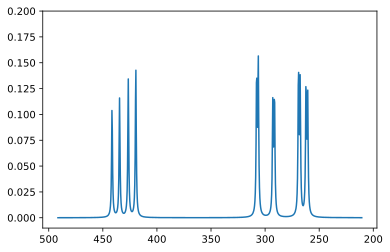

In [11]:
mplplot(abx_system.peaklist(), y_max=0.2);

To plot the spectra as a "stick" style plot (single lines for each peak, rather than a simulated lineshape), you can use the mplplot_stick function instead of mplplot:

In [12]:
from nmrtools.plt import mplplot_stick

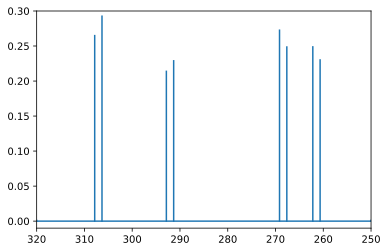

In [13]:
# The range of the x axis can be specified using the 'limits' keyword argument:
mplplot_stick(abx_system.peaklist(), y_max=0.3, limits=(250, 320));

SpinSystem defaults to second-order simulation of a spin system. If the SpinSystem object is instantiated with the `second_order=False` keyword argument, or if the SpinSystem.second_order attribute is set to `False`, first-order simulation will be performed instead.

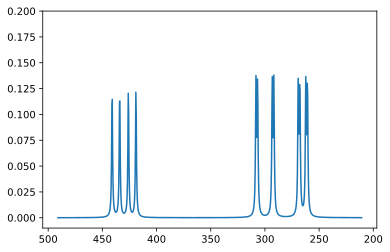

In [14]:
abx_system.second_order = False
mplplot(abx_system.peaklist(), y_max=0.2);

Depending on the resolution of the plot and how the data points for the lineshape are interpolated, the peak heights may not look identical. The correct relative intensities can be seen in the stick plot, however:

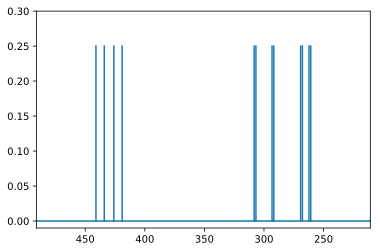

In [15]:
mplplot_stick(abx_system.peaklist(), y_max=0.3);

### Method B: using the lower-level API

The `nmrtools.qm` module provides functions for the quantum-mechanical calculation of NMR spectra.

In [16]:
from nmrtools import qm

In [17]:
peaklist = qm.spectrum(v, J, normalize=True)  # TODO: refactor "spectrum" to "peaklist"
peaklist


AttributeError: module 'nmrtools.qm' has no attribute 'spectrum'

When `normalize=True`, the total intensities should add up to the total number of nuclei in the spin system.

Note that a peaklist \[(v, I)...] format can be easily converted to separate lists for [v...] and [I...] using:
```python
v, I = zip(*peaklist)
```
This is similar in effect to taking the transpose of a matrix.

In [ ]:
x, y = zip(*peaklist)
print(y)  # tuple of intensities
print("Total intensity: %.2f" % sum(y))  # total intensity to 2 decimal places

In [ ]:
mplplot(peaklist, y_max=0.2);

The `nmrtools.firstorder` module provides functions for calculating first-order NMR spectra. The `first_order_spin_system` functon accepts the same v, J inputs as for a second-order computation.

In [ ]:
from nmrtools.firstorder import first_order_spin_system

In [ ]:
peaklist = first_order_spin_system(v, J)
mplplot(peaklist, y_max=0.2);

## Scenario: User wants to simulate individual first-order multiplets

The Multiplet class can be used to represent an individual first-order multiplet.

In [ ]:
from nmrtools import Multiplet

Required arguments for Multiplet are the central frequency `v`, the intensity `I` ("integration") in the absence of coupling, and a list of coupling data `J`. These arguments become attributes of Multiplet. Each list entry is a tuple of (J value in Hz, number of nuclei causing the coupling). For example, the following Multiplet represents: 1200 Hz, 2H, td, J = 7.1, 1.1 Hz.

In [ ]:
# 1200 Hz, 2H, td, J= 7.1, 1.1 Hz
td = Multiplet(1200.0, 2, [(7.1, 2), (1.1, 1)])
print(td.v)
print(td.I)
print(td.J)

The `Multiplet.peaklist()` method returns the peaklist for the multiplet:

In [ ]:
mplplot_stick(td.peaklist());

In [ ]:
mplplot(td.peaklist());

Multiplet attributes can be modified. 

In [ ]:
td2 = Multiplet(1200.0, 2, [(7.1, 2), (1.1, 1)])
td2.v = 1100
mplplot(td2.peaklist());

If a Multiplet is multiplied by a scalar, a new Multiplet is returned that has all intensities multiplied by the scalar. In-place multiplication (`*=`) modifies the original Multiplet object.

In [ ]:
td3 = td2 * 2
td2 *= 2
assert td2 is not td3
mplplot(td2.peaklist());

Multiplets are equal to each other if their peaklists are equal.

In [ ]:
assert td2 == td3

Division and division in place is also possible:

In [ ]:
td4 = td2 / 2
td2 /= 2
assert td4 == td2

If two multiplets are added together, the result is a `Spectrum` object. See the next Scenario for the usage of `Spectrum`.

## Scenario: User wants to simulate a spectrum built from individual components

Any object that has a `.peaklist()` method can be used to create a Spectrum object.

A Spectrum object can be specifically created by providing a list of components as the first argument:

In [ ]:
# TODO: consider an abstract base class that has .peaklist() and ._refresh() methods, and that supports __add__.

In [ ]:
from nmrtools import Spectrum

In [ ]:
two_td = Spectrum([td, td3])

In [ ]:
mplplot(two_td.peaklist());

A Spectrum object is also returned from certain binary operations, such as addition:

In [ ]:
td3.v = 1000
td4.v = 900

all_tds = td + td2 + td3 + td4
mplplot(all_tds.peaklist());

A Spectrum can be composed from both first- and second-order components:

In [ ]:
combo_spectrum = abx_system + td3 + td4

# mplplot has an optional y_max keyword argument to set the max range of the y-axis
mplplot(combo_spectrum.peaklist(), y_max=0.4);

## Scenario: User wants to model a specific spin system using an explicit (non-qm) solution

The nmrtools.partial module contains "canned" mathematical solutions for second-order systems.

Example: simulate the AB part of an ABX<sub>3</sub> system

In [ ]:
from nmrtools.partial import ABX3

In [ ]:
help(ABX3)

In [ ]:
abx3_peaklist = ABX3(-12, 7, 7, 14, 150)
mplplot(abx3_peaklist, y_max=0.25);

Here is an alternate, non-qm simulation for the ABX system from the SpinSystem demonstration:

In [ ]:
from nmrtools.partial import ABX

In [ ]:
help(ABX)

In [ ]:
abx_peaklist = ABX(1.5, 7, 15, 35, 282.5)
mplplot(abx_peaklist, y_max=0.4);

In [ ]:
# TODO: better implement x limits in plot routines

## Scenario: User wants to model DNMR two-spin exchange, without and with coupling

The nmrtools.dnmr library provides functions for calculating DNMR lineshapes, and classes to describe these systems. Currently, models for two uncoupled nuclei and two coupled nuclei are provided.

In [ ]:
from nmrtools.dnmr import DnmrTwoSinglets, DnmrAB

For: v<sub>a</sub> = 165 Hz, v<sub>b</sub> = 135 Hz, k = 65.9 {todo: units}, line widths (at the slow exchange limit) w<sub>a</sub> and w<sub>b</sub> = 0.5 Hz, and population of state a = 0.5 (i.e. 50%):

In [ ]:
two_singlet_system = DnmrTwoSinglets(165.00, 135.00, 65.9, 0.50, 0.50, 0.50)

In [ ]:
from nmrtools.plt import mplplot_lineshape

In [ ]:
mplplot_lineshape(*two_singlet_system.spectrum());  

Class attributes can be changed. In the previous case, k = 65.9 corresponds to the point of coalescence. When the rate of exchange is lower, two separate peaks are observed.

In [ ]:
two_singlet_system.k = 5

In [ ]:
mplplot_lineshape(*two_singlet_system.spectrum());

What if the relative populations of states a and b are 75% and 25%, respectively?

In [ ]:
two_singlet_system.pa = 0.75
mplplot_lineshape(*two_singlet_system.spectrum());

To model an AB-like system of two coupled nuclei undergoing exchange, use the DnmrAB class. In the following example, the frequencies are the same as for the previous system. J = 5 Hz, k = 12 {units}, and the line width (at the slow exchange limit) is 0.5 Hz.

In [ ]:
from nmrtools.dnmr import DnmrAB

In [ ]:
AB = DnmrAB(165, 135, 5, 10, 0.5)

In [ ]:
mplplot_lineshape(*AB.spectrum());